_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-05-21, 9am

Student name: FILL IN YOUR NAMES HERE

# Exercise sheet 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `np.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import oopsi_fix2
from scipy.stats import pearsonr

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv('../data/nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv('../data/nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv('../data/nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv('../data/nda_ex_4_gcamp2_spikes.csv', header=0)  


In [7]:
ogb_calcium.fillna(0, inplace=True);
ogb_spikes.fillna(0, inplace=True);
gcamp_calcium.fillna(0, inplace=True);
gcamp_spikes.fillna(0, inplace=True);

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

In [9]:
ogb_spikes_asm = signal.decimate(ogb_spikes.iloc[:,4], 4);
ogb_calcium_asm = signal.decimate(ogb_calcium.iloc[:,4], 4);

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


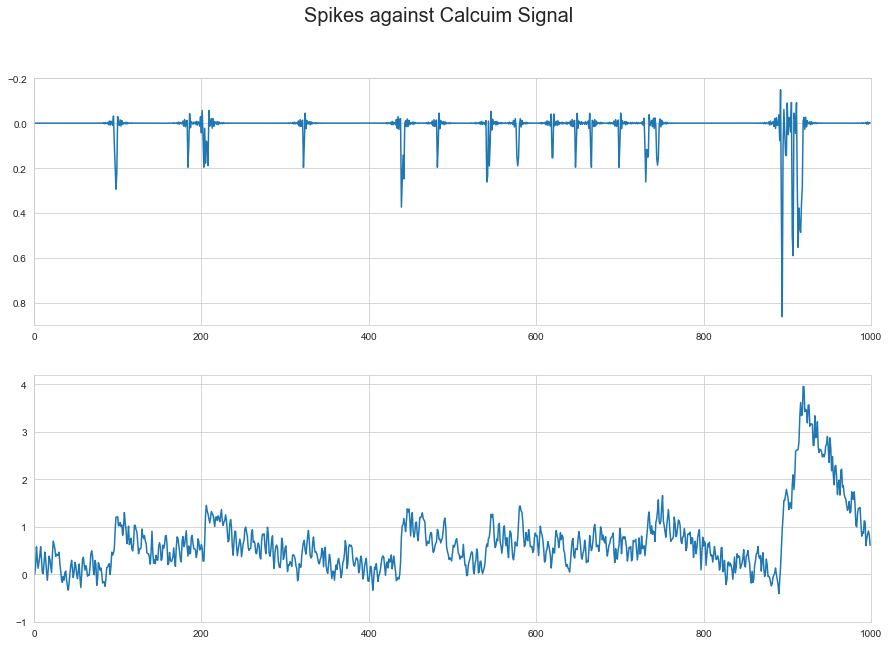

In [10]:
n = 1000;
t = np.arange(0,n);

plt.figure(figsize=(15, 10));
plt.suptitle('Spikes against Calcuim Signal',fontsize=20);

plt.subplot(2,1,1)
plt.plot(t,ogb_spikes_asm[0:n]);
plt.xlim((0,n));
plt.ylim(-0.2,.9);
plt.gca().invert_yaxis()

plt.subplot(2,1,2)
plt.plot(t,ogb_calcium_asm[0:n]);
plt.xlim((0,n));
plt.ylim(-1,4.2);

plt.show();

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


In [11]:
def deconv_ca(ca, sp, tau):
# Compute the deconvolved calcium signal 
#   sp_hat = deconv_ca(ca, sp, tau) computes the deconvolved calcium signal
#   using the indicator dependent exponential calicum kernel.
#
#   ca:    1 by T
#   sp:    1 by T
#   tau:   1 by 1
#
#   sp_hat: 1 by T

   # fill your code here
    t = np.arange(0, 10*tau, 1/25);
    kernel = np.exp(-t/tau);
    
    sp_hat, _ = signal.deconvolve(ca, kernel);
    
    sp_hat[sp_hat<0] = 0;
    return sp_hat

#### Apply the function to the example OGB cell

In [12]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .5
sp_hat = deconv_ca(ca, sp, tau)
print(sp.shape)
print(sp_hat.shape)

(17997,)
(17873,)


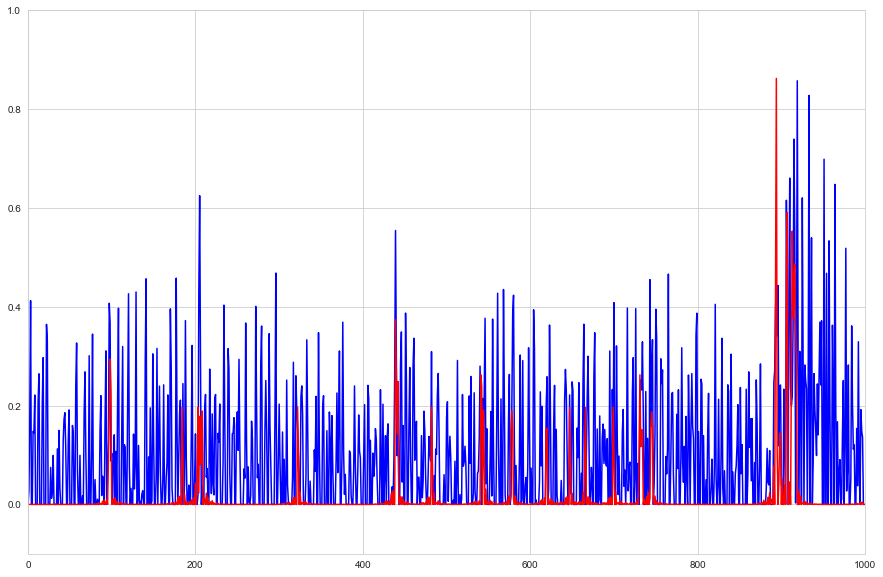

In [13]:
# fill in plot here

plt.figure(figsize=(15, 10));

plt.plot(t,sp_hat[0:n], color='b');
plt.plot(t,sp[0:n], color='r');

plt.xlim((0,n));
plt.ylim(-0.1,1);
plt.show();

### Apply the function to the example GCamP cell

In [14]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts


tau = .1

sp_hat = deconv_ca(ca, sp, tau)

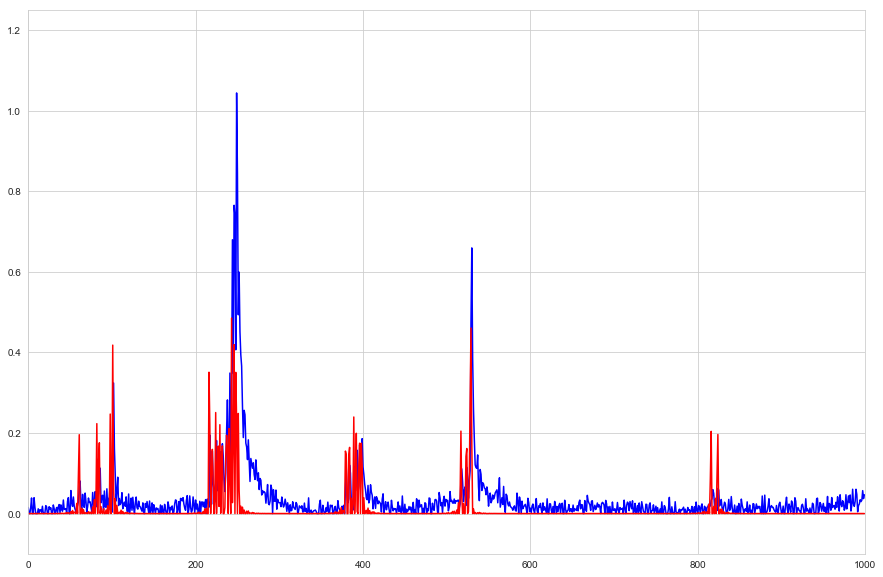

In [17]:
# fill in plot here

plt.figure(figsize=(15, 10));

plt.plot(t,sp_hat[0:n]/10, color='b');
plt.plot(t,sp[0:n], color='r');

plt.xlim((0,n));
plt.ylim(-0.1,1.25);
plt.show();

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Note: If you have troubles with installing one of them maybe try another.

*Grading: 2 pts*



In [20]:
idx = 4;
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4);
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4);
sp[sp<0] = 0; # remove decimation artefacts
dt = 1/25;

# fast-oopsi,
d_f,Cz = oopsi_fix2.fast(ca,dt=dt,iter_max=6);

# wiener filter,
d_w,Cw = oopsi_fix2.wiener(ca,dt=dt,iter_max=100);

# descritized binning,
d_d,v = oopsi_fix2.discretize(ca,bins=[0.75]);

# fill in algorithm here

[0.10297538 0.11207228 0.12082682 ... 0.68481648 0.78216698 0.89053545]


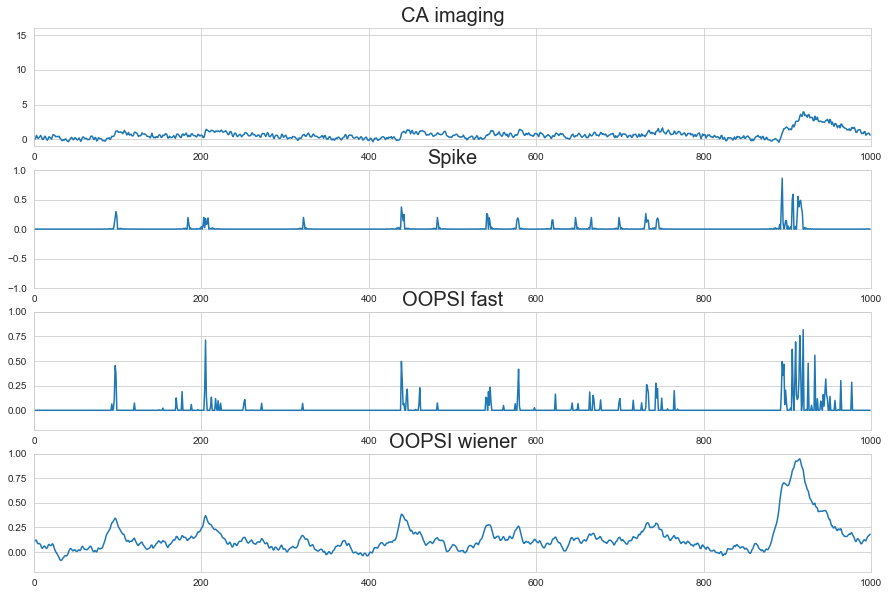

In [21]:
# fill in plot here

plt.figure(figsize=(15, 10));

plt.subplot(4,1,1)
plt.plot(t,ca[0:n]);
plt.xlim((0,n));
plt.ylim(-1,16);
plt.title(label = 'CA imaging', fontsize = 20);

plt.subplot(4,1,2)
plt.plot(t,sp[0:n]);
plt.xlim((0,n));
plt.ylim(-1,1);
plt.title(label = 'Spike', fontsize = 20);

plt.subplot(4,1,3)
plt.plot(t,d_f[0:n]);
plt.xlim((0,n));
plt.ylim(-0.2,1);
plt.title(label = 'OOPSI fast', fontsize = 20);

plt.subplot(4,1,4)
plt.plot(t,d_w[0:n]);
plt.xlim((0,n));
plt.ylim(-0.2,1);
plt.title(label = 'OOPSI wiener', fontsize = 20);

plt.show();

In [22]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

# fill in algorithm here

# fast-oopsi,
d_f,Cz = oopsi_fix2.fast(ca,dt=dt,iter_max=6);

# wiener filter,
d_w,Cw = oopsi_fix2.wiener(ca,dt=dt,iter_max=100);

# descritized binning,
d_d,v = oopsi_fix2.discretize(ca,bins=[0.75]);

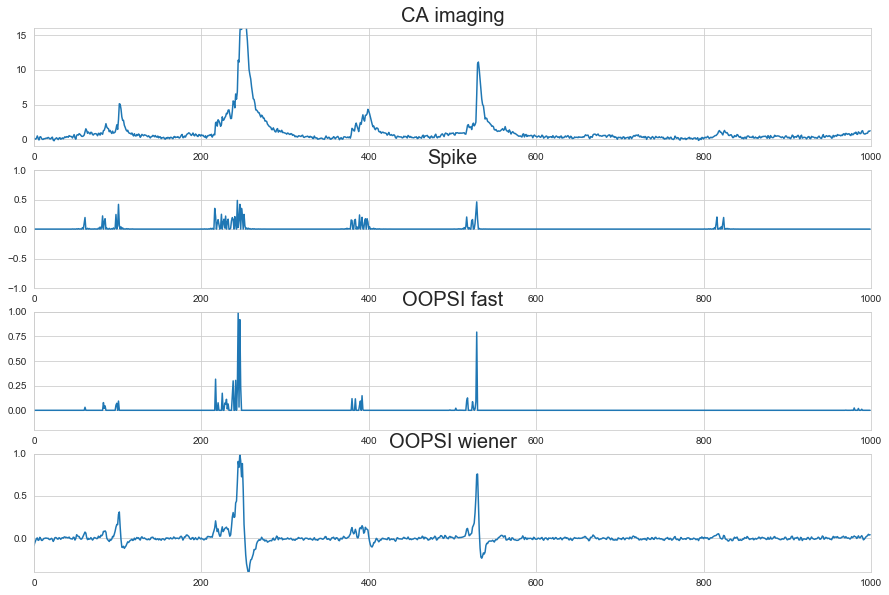

In [23]:
# fill in plot here

plt.figure(figsize=(15, 10));

plt.subplot(4,1,1)
plt.plot(t,ca[0:n]);
plt.xlim((0,n));
plt.ylim(-1,16);
plt.title(label = 'CA imaging', fontsize = 20);

plt.subplot(4,1,2)
plt.plot(t,sp[0:n]);
plt.xlim((0,n));
plt.ylim(-1,1);
plt.title(label = 'Spike', fontsize = 20);

plt.subplot(4,1,3)
plt.plot(t,d_f[0:n]);
plt.xlim((0,n));
plt.ylim(-0.2,1);
plt.title(label = 'OOPSI fast', fontsize = 20);

plt.subplot(4,1,4)
plt.plot(t,d_w[0:n]);
plt.xlim((0,n));
plt.ylim(-0.4,1);
plt.title(label = 'OOPSI wiener', fontsize = 20);

plt.show();

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation coefficient between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [24]:
corr_fast = np.zeros(11);
corr_wiener = np.zeros(11);
corr_decon = np.zeros(11);

for i in range(11):
    
    ca = signal.decimate(ogb_calcium.iloc[:,i], 4);
    sp = signal.decimate(ogb_spikes.iloc[:,i], 4);
    sp[sp<0] = 0; # remove decimation artefacts    
    where_are_NaNs = np.isnan(sp);
    sp[where_are_NaNs] = 0;
    where_are_NaNs = np.isnan(ca);
    ca[where_are_NaNs] = 0;
    
    # fast-oopsi,
    d_f,Cf = oopsi_fix2.fast(ca,dt=dt,iter_max=6);

    # wiener filter,
    d_w,Cw = oopsi_fix2.wiener(ca,dt=dt,iter_max=100);    
    
    sp_hat = deconv_ca(ca, sp, tau);
    
    
    
    corr_d_f = np.corrcoef(sp, d_f);
    corr_d_w = np.corrcoef(sp, d_w);
    corr_sp_hat = np.corrcoef(sp[:len(sp_hat)], sp_hat);
    
    corr_fast[i] = corr_d_f[0][1];
    corr_wiener[i] = corr_d_w[0][1];
    corr_decon[i] = corr_sp_hat[0][1];
    


Create OGB dataframe

In [26]:
where_are_NaNs = np.isnan(corr_decon);
corr_decon[where_are_NaNs] = 0;
where_are_NaNs = np.isnan(corr_fast);
corr_fast[where_are_NaNs] = 0;
where_are_NaNs = np.isnan(corr_wiener);
corr_wiener[where_are_NaNs] = 0;

In [27]:
df_ogb1 = pd.DataFrame(columns=['Ogb deconv_ca', 'Ogb fast', 'Ogb wiener']);

for i in range(11):
    df_ogb1 = df_ogb1.append({'Ogb deconv_ca' : corr_decon[i], 'Ogb fast': corr_fast[i], 'Ogb wiener': corr_wiener[i]}, ignore_index=True);


Evaluate on GCamp data

In [28]:
corr_fast = np.zeros(37);
corr_wiener = np.zeros(37);
corr_decon = np.zeros(37);

for i in range(37):
    
    ca = signal.decimate(gcamp_calcium.iloc[:,i], 4);
    sp = signal.decimate(gcamp_spikes.iloc[:,i], 4);
    sp[sp<0] = 0; # remove decimation artefacts    
    where_are_NaNs = np.isnan(sp);
    sp[where_are_NaNs] = 0;
    where_are_NaNs = np.isnan(ca);
    ca[where_are_NaNs] = 0;
    
    Cf = 1;
    Cw = 1;
    # fast-oopsi,
    d_f,Cf = oopsi_fix2.fast(ca,dt=dt,iter_max=6);

    # wiener filter,
    d_w,Cw = oopsi_fix2.wiener(ca,dt=dt,iter_max=100);    
    
    sp_hat = deconv_ca(ca, sp, tau);
    
    
    
    corr_d_f = np.corrcoef(sp, d_f);
    corr_d_w = np.corrcoef(sp, d_w);
    corr_sp_hat = np.corrcoef(sp[:len(sp_hat)], sp_hat);
    
    corr_fast[i] = corr_d_f[0][1];
    corr_wiener[i] = corr_d_w[0][1];
    corr_decon[i] = corr_sp_hat[0][1];



Create GCamp dataframe

In [29]:
df_gcamp = pd.DataFrame()

In [30]:
df_gcamp = pd.DataFrame(columns=['Gcamp deconv_ca', 'Gcamp fast', 'Gcamp wiener']);

where_are_NaNs = np.isnan(corr_decon);
corr_decon[where_are_NaNs] = 0;
where_are_NaNs = np.isnan(corr_fast);
corr_fast[where_are_NaNs] = 0;
where_are_NaNs = np.isnan(corr_wiener);
corr_wiener[where_are_NaNs] = 0;

for i in range(37):
    df_gcamp = df_gcamp.append({'Gcamp deconv_ca' : corr_decon[i], 'Gcamp fast': corr_fast[i], 'Gcamp wiener': corr_wiener[i]}, ignore_index=True);
    

Combine both dataframes and plot

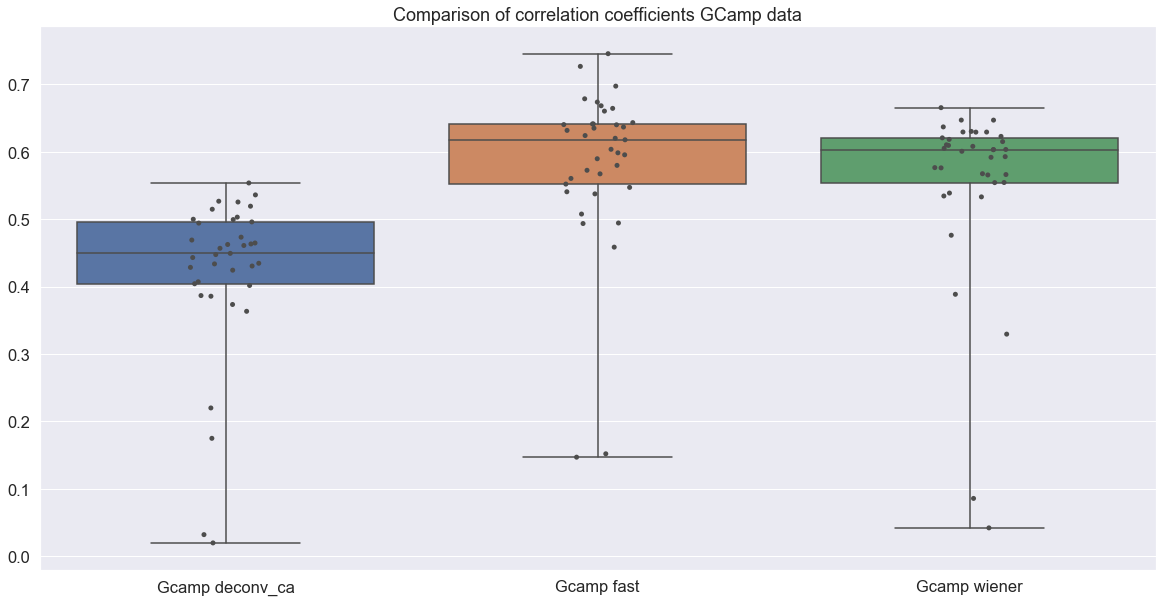

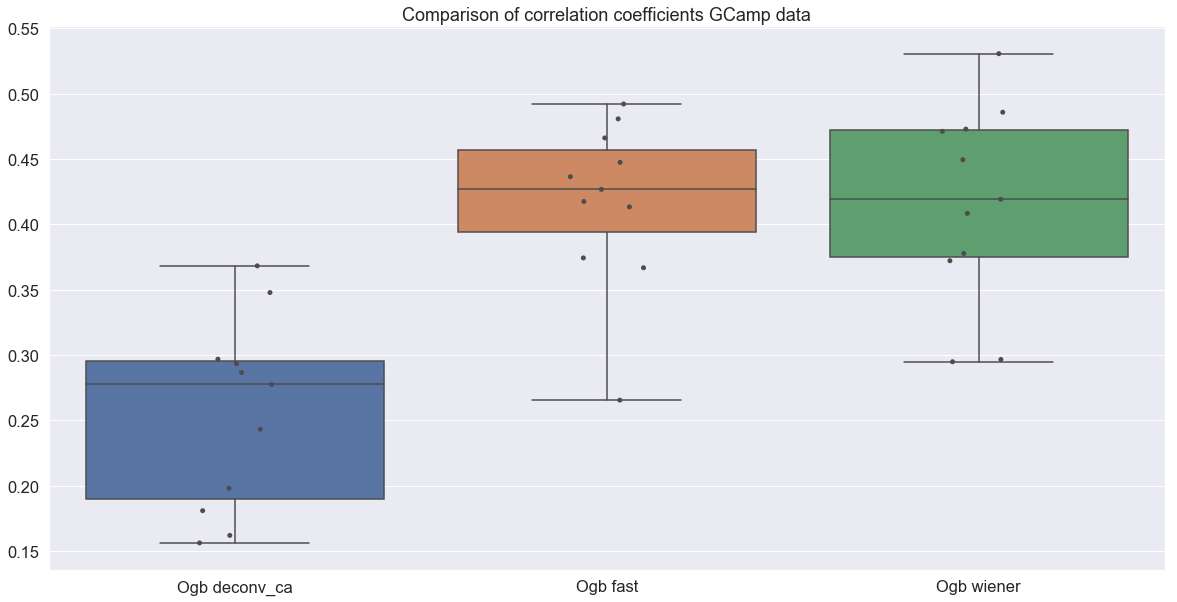

In [31]:
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid");
sns.set(font_scale=1.5);
sns.boxplot(data = df_gcamp, whis=np.inf);
sns.stripplot(data = df_gcamp, color='.3');
plt.title("Comparison of correlation coefficients GCamp data");
plt.show();

plt.figure(figsize=(20, 10));           
sns.set_style("whitegrid");
sns.set(font_scale=1.5);
sns.boxplot(data = df_ogb1, whis=np.inf);
sns.stripplot(data = df_ogb1, color='.3');
plt.title("Comparison of correlation coefficients GCamp data");
plt.show();
